In [1]:
import numpy as np
import obspy
from obspy import read
import pandas as pd
import time
import scipy
import random

from __future__ import print_function
import keras
from keras.layers import add, Reshape, Dense,Input, TimeDistributed, Dropout, Activation, LSTM, Conv2D, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l1
from keras import backend as K
from keras.models import Model, load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import os
np.seterr(divide='ignore', invalid='ignore')
import h5py
#from obspy.signal.trigger import trigger_onset
np.warnings.filterwarnings('ignore')

### read data

In [2]:
noise_filename = pd.read_csv('noise.csv', header = None)
noise_trace = []
for i in noise_filename[0]:
    temp = obspy.read("data/noise/" + i)
    te = [temp[0],temp[1],temp[2]]
    noise_trace.extend(te)
    
signal_filename = pd.read_csv('signal.csv', header = None)
signal_trace = []
for i in signal_filename[0]:
    temp = obspy.read("data/signal/" + i)
    te = [temp[0],temp[1],temp[2]]
    signal_trace.extend(te)

### data slice

In [3]:
def slice_trace(tr):
    start_time = tr.stats.starttime
    end_time = tr.stats.endtime
    gap = (end_time - start_time)/4
    tr = tr.slice(start_time + gap, end_time - gap)
    return tr


def slice_sig(tr_type, list_type):
    sampling_rate = 31.25
    p_win = (.5, 3)
    out_trace = []
    out_y = np.zeros(shape = (len(tr_type), 62, 1))
    for i in range(len(tr_type)):
        cut = int((list_type[i]*p_win[1]+p_win[0])*sampling_rate)
        tr = tr_type[i]
        tr.data = tr.data[cut:1000+cut]
        s = int(np.around(((1000-cut)/1000)*62, decimals=0))
        y_truth = np.append(np.zeros(shape=(s,1)), np.ones(shape=(62-s,1)),axis=0)
        out_trace.append(tr)
        out_y[i] = y_truth
    return out_trace, out_y

In [4]:
random.seed(0)
list1=[]
for i in range(len(signal_trace)):
    k = random.random()
    list1.append(k)

In [5]:
noise_trace = list(map(slice_trace, noise_trace))
signal_trace, signal_y = slice_sig(signal_trace, list1)
noise_y = np.zeros(shape = (len(noise_trace), 62, 1))

### data preprocess

In [6]:
def preprocess(tr):
    #band-pass filter between 1 and 45 Hz
    tr = [n.filter("bandpass", freqmin=1, freqmax=45) for n in tr]
    #resample at 100 HZ
    tr = [n.resample(200) for n in tr]
    #detrende all the traces by removing the mean
    tr = [n.detrend("demean") for n in tr]
    #normalize
    tr = [n.normalize() for n in tr]
    return tr

In [7]:
# Preprocess
noise_trace = preprocess(noise_trace)
signal_trace = preprocess(signal_trace)

### STFT

In [49]:
#change the nperseg from 40 to 52 and check the shape
f, t, Zxx = signal.stft(signal_trace[0], fs = 100, nperseg=51)
Zxx.shape
print(len(t))

248


In [9]:
## accordingly change the shape here
def STFT(tr):
    tr_length = len(tr)
    Zxx_tr = np.zeros(shape = (tr_length, 248, 26, 1))
    for i in range(tr_length):
        f, t, Zxx = signal.stft(tr[i], fs = 100, nperseg=51)
        temp = np.zeros(shape = (1, 26, 248))
        temp[0] = Zxx
        Zxx_tr[i] = np.abs(temp).T
    return Zxx_tr

In [10]:
Zxx_signal = STFT(signal_trace)
Zxx_noise = STFT(noise_trace)

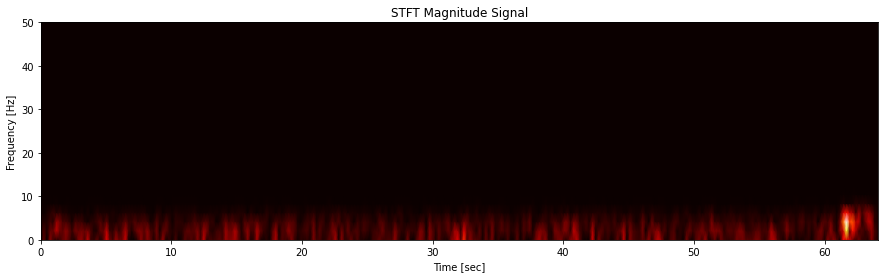

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
fs, ts, Zxxs = signal.stft(signal_trace[15], fs = 100, nperseg=48)
plt.pcolormesh(ts, fs, np.abs(Zxxs), shading='gouraud',cmap = 'hot')
plt.title('STFT Magnitude Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

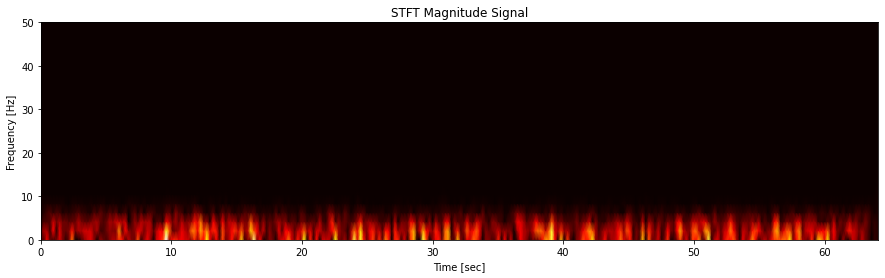

In [50]:
fig, ax = plt.subplots(figsize=(15, 4))
fs, ts, Zxxs = signal.stft(noise_trace[15], fs = 100, nperseg=48)
plt.pcolormesh(ts, fs, np.abs(Zxxs), shading='gouraud',cmap = 'hot')
plt.title('STFT Magnitude Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [11]:
y = np.append(noise_y, signal_y, axis = 0)
X_Zxx = np.append(Zxx_noise, Zxx_signal, axis = 0)
print(y.shape)
print(X_Zxx.shape)

(57219, 62, 1)
(57219, 248, 26, 1)


### shuffle

In [12]:
np.random.seed(15)
X, X_test, y, y_test = train_test_split(X_Zxx, y, test_size=0.05, random_state=15,shuffle=True)

### CRED Model Training

In [13]:
def lr_schedule(epoch):
    """
    Learning rate is scheduled to be reduced after 40, 60, 80, 90 epochs.
    """
    lr = 1e-3
    if epoch > 60:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [14]:
def block_CNN(filters, ker, inpC): 
    """
    Returns CNN residual blocks
    """
    layer_1 = BatchNormalization()(inpC) 
    act_1 = Activation('relu')(layer_1) 

    conv_1 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_1) 
    
    layer_2 = BatchNormalization()(conv_1) 
    act_2 = Activation('relu')(layer_2) 
  
    conv_2 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_2)
    
    layer_3 = BatchNormalization()(conv_2) 
    act_3 = Activation('relu')(layer_3)
    
    conv_3 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_3)
    
    return(conv_3)

In [15]:
def block_BiLSTM(inpR, filters, rnn_depth):
    """
    Returns LSTM residual blocks
    """
    x = inpR
    for i in range(rnn_depth):
        x_rnn = Bidirectional(LSTM(filters, return_sequences=True))(x)
        x_rnn = Dropout(0.7)(x_rnn)
        if i > 0 :
            x = add([x, x_rnn])
        else:
            x = x_rnn      
    return x

In [16]:
def model_cred(shape, filters):
    
    inp = Input(shape=shape, name='input')

    conv2D_2 = Conv2D(filters[0], (9,9), strides = (2,2), padding = 'same', activation = 'relu')(inp) 
    res_conv_2 = keras.layers.add([block_CNN(filters[0], 9, conv2D_2), conv2D_2]) 

    conv2D_3 = Conv2D(filters[1], (5,5), strides = (2,2), padding = 'same', activation = 'relu')(res_conv_2) 
    res_conv_3 = keras.layers.add([block_CNN(filters[1], 5, conv2D_3),conv2D_3]) 
    
    shape = K.int_shape(res_conv_3)   
    reshaped = Reshape((shape[1], shape[2]*shape[3]))(res_conv_3)
    
    res_BIlstm = block_BiLSTM(reshaped, filters = filters[3], rnn_depth = 2)
 
    UNIlstm = LSTM(filters[3], return_sequences=True)(res_BIlstm)
    UNIlstm = Dropout(0.8)(UNIlstm)  
    UNIlstm = BatchNormalization()(UNIlstm)
   
    dense_2 = TimeDistributed(Dense(filters[3], kernel_regularizer=l1(0.01), activation='relu'))(UNIlstm)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(0.8)(dense_2)
    
    dense_3 = TimeDistributed(Dense(1, kernel_regularizer=l1(0.01), activation='sigmoid'))(dense_2)

    out_model = Model(inputs=inp, outputs=dense_3)
    return out_model

In [17]:
early_stopping_monitor = EarlyStopping(patience=5)
    
lr_scheduler = LearningRateScheduler(lr_schedule)
    
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5-2,
                                   min_lr=5e-5)

In [18]:
model = model_cred((248, 26, 1), filters = [8, 16, 32, 64, 128, 256])
model.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(lr=lr_schedule(0)),
                  metrics=['binary_accuracy'])
model.summary()

Metal device set to: Apple M1


2022-03-13 15:34:39.333155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-13 15:34:39.335041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 248, 26, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 124, 13, 8)   656         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 13, 8)  32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                        

 rmalization)                                                                                     
                                                                                                  
 dropout_3 (Dropout)            (None, 62, 64)       0           ['batch_normalization_7[0][0]']  
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 62, 1)       65          ['dropout_3[0][0]']              
 buted)                                                                                           
                                                                                                  
Total params: 264,137
Trainable params: 263,737
Non-trainable params: 400
__________________________________________________________________________________________________


In [19]:
seed_value = 15
tf.random.set_seed(seed_value)

In [20]:
checkpointer = ModelCheckpoint(filepath='model_best_07.hdf5',
                                       monitor='val_loss', verbose=0, mode='auto', save_best_only=True)
start_time = time.time()  
history = model.fit(
    X,
    y,
    epochs=200,
    batch_size=500,
    verbose=0,
    validation_split = 0.2,
    max_queue_size=5,
    callbacks = [checkpointer, lr_reducer, lr_scheduler, early_stopping_monitor] )
end_time = time.time()

2022-03-13 15:35:04.054121: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Learning rate:  0.001


2022-03-13 15:35:08.412834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 15:35:09.678257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 15:35:09.701333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 15:35:10.036847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 15:35:10.050598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 15:35:10.307307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 15:35:10.704234: I tensorflow/core/grappler/optimizers/cust

Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  1e-05
Learning rate:  1e-05
Learning rate:  1e-05


In [21]:
model.save("final_model_07.h5")

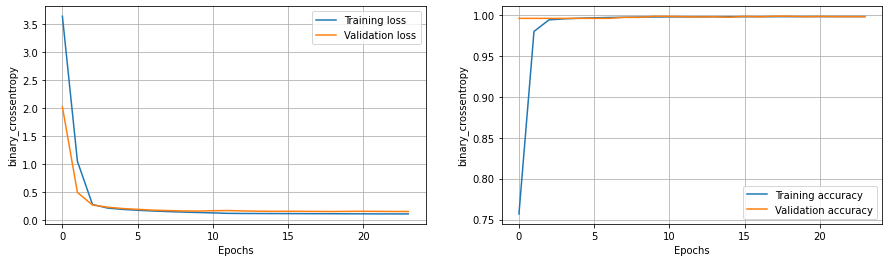

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))

axes[0].plot(history.history['loss'],label='Training loss')
axes[0].plot(history.history['val_loss'],label='Validation loss')
axes[0].set_ylabel('binary_crossentropy', fontsize=10)
axes[0].set_xlabel('Epochs', fontsize=10)
axes[0].legend()
axes[0].grid()

axes[1].plot(history.history['binary_accuracy'],label='Training accuracy')
axes[1].plot(history.history['val_binary_accuracy'],label='Validation accuracy')
axes[1].set_ylabel('binary_crossentropy', fontsize=10)
axes[1].set_xlabel('Epochs', fontsize=10)
axes[1].legend()
axes[1].grid()

### detection

In [23]:
def label(prob):
    prediction = np.zeros(shape = prob.shape)
    for i in range(len(prob)):
        if prob[i] > 0.3:
            prediction[i] = 1
    return prediction

In [24]:
def detection(tr):
    '''
    ----------------------------------
    Input:
    st: the input should be a wave stream with the same scale of the training data, which is three chanel of the wave,
        in which channel there are 1000 data points
    ----------------------------------
    Output:
    return: time detected time of p-wave arrival; and if there is no signal, print('No p-wave signal') and return None
    '''
    tr = tr.filter("bandpass", freqmin=1, freqmax=45)
    tr = tr.resample(200)
    tr = tr.detrend("demean")
    tr = tr.normalize()
 
    # stft
    f, t, Zxx = signal.stft(tr, fs = 100, nperseg=51)
    temp = np.zeros(shape = (1, 26, 248))
    temp[0] = Zxx
    ip = np.zeros(shape = (1,248,26,1))
    ip[0] = np.abs(temp).T
    
    # input into model
    y_prob = model.predict(ip)
    y = label(y_prob[0])
    
    # time output
    if np.all(y == 0):
        print("No p-wave signal")
        return None
    else:
        t = np.argwhere(y==1)[0][0] ## get the index of the first '1' appear in the prediction
        lap = tr.stats.endtime - tr.stats.starttime
        arrival_time = tr.stats.starttime + lap / 62 * t
        print('p-wave arrivies at', arrival_time)
        return arrival_time

In [51]:
model = load_model("final_model_51_3CNN_200_06.h5")

In [52]:
y_pred = model.predict(X_test)

2022-03-13 20:23:53.124163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 20:23:54.438854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 20:23:54.449222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 20:23:55.111218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 20:23:55.126370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-13 20:23:55.410208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


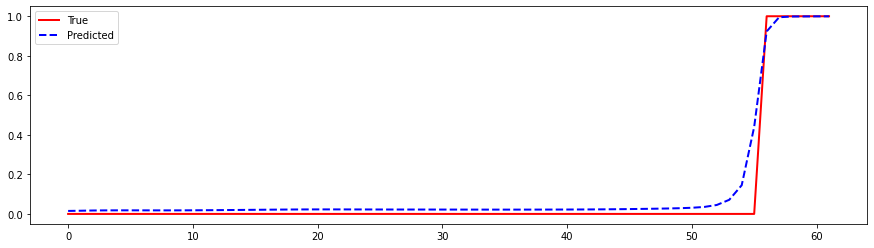

In [68]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(y_test[171].squeeze(), color='r', linewidth=2, label='True')
plt.plot(y_pred[171].squeeze(),'--', color='b', linewidth=2, label='Predicted')
plt.legend()
plt.show()